#                Stochastic Clogging Prediction Analysis

## Loading Libraries and Modules

In [131]:
### Loading base libraries
import sys, os
import numpy as np
import warnings #prevent "future warning" errors
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pandas.api.types import is_string_dtype
import eli5

#Importing pre-proccesing libraries
from eli5.sklearn import PermutationImportance
from sklearn.base import clone 
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, \
                            explained_variance_score, \
                            confusion_matrix, \
                            accuracy_score, \
                            roc_curve, \
                            auc, \
                            roc_auc_score, \
                            average_precision_score, \
                            mean_absolute_error

#loading classifier models and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

#Loading regressiom models
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

#loading plotting modules
import plotly.offline as py
import plotly.graph_objs as go
import plotly_express as px    
    
#changing default figure renderer for github
import plotly.io as pio
pio.renderers
pio.renderers.default = "svg"

#display all column in pandas head
#pd.set_option('display.max_columns', None)
    
# other modules
import joblib
import datetime


## Other Functions 

In [115]:
##Defining Correlation Data function

def correlationData(data):
    # Look at correlations between features (from precept 6)
    plt.figure(figsize = (5,5), dpi=200)
    plt.matshow(data.corr(), fignum=1, cmap=plt.cm.bwr)
    cols = list(data.columns)
    plt.xticks(list(range(len(cols))), cols, rotation=90)
    plt.yticks(list(range(len(cols))), cols)
    plt.colorbar()
        
#correlationData(apData)

## Defining feature importances by droping collums for random forests
#https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

def dropcol_importances(model, X_train, y_train):
    model_ = clone(model)
    model_.random_state = 999
    model_.fit(X_train, y_train)
    baseline = model_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        model_ = clone(model)
        model_.random_state = 999
        model_.fit(X, y_train)
        o = model_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance',ascending = False)
    return I

##Defining Random Forest Classifier

def RFClassifierDropCol(trainData, trainResult, testData, testResult):
        
    ##Doing Random Forest classifier 
    log = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0,oob_score=True)
    log.fit(trainData,trainResult) 
    prediction = log.predict(testData)
    probs = log.predict_proba(testData)
    probs = probs[:, 1]
    score = log.score(testData,testResult)
    print("Random Forests")
    print("Accuracy:",score)
    print("Precision Score:",average_precision_score(testResult,prediction))
    print("ROC area under curve:", roc_auc_score(testResult,probs))
    print("\n classification report: \n",classification_report(testResult,prediction))
    print(confusion_matrix(testResult,prediction))
    tn, fp, fn, tp = confusion_matrix(testResult,prediction).ravel()
    print("True Negatives:", tn)
    print("False Negatives:", fn)
    print("True Positives:", tp)
    print("False Positives:", fp, "\n")  
    
    #feature importances using Drop Column method
    bestFeaturesDP = dropcol_importances(log, trainData, trainResult)
    
    return [score, average_precision_score(testResult,prediction), roc_auc_score(testResult,probs)], bestFeaturesDP


##Doing function that rounds to the nearest significant digits
from math import log10, floor 

def roundTo1(x): #1 sig figs
    if x != 0:
        return round(x, -int(floor(log10(abs(x)))))
    else:
        return x
    
def roundTo2(x): #2 sig figs
    if x != 0:
        return round(x, -int(floor(log10(abs(x)))-1))    
    else:
        return x
    
## Defining Function that allows us to visualize the effects of changing variables while 
#  keeping another one constant

def comparingFeatures(targetFeature,targetValue,comparisonFeatures, sigFigs):
      
    roundedData1 = data.copy()
    roundedData1[features] = roundedData1[features].applymap(roundTo1)
    roundedData2 = data.copy()
    roundedData2[features] = roundedData2[features].applymap(roundTo2)
    
    if sigFigs == 1: 
            targetIndeces = roundedData1.index[roundedData1[targetFeature] == targetValue].tolist()
        
    elif sigFigs == 2:
            targetIndeces = roundedData2.index[roundedData2[targetFeature] == targetValue].tolist()
    else:
        print("Choose Either 1 or 2 sig. figs.")
        
    #assemble data set    
    comparisonDataSet = roundedData2.loc[targetIndeces]
    print("Comparison Data Size:", comparisonDataSet.shape)
    
    return comparisonDataSet[comparisonFeatures]




## Loading, Exploring, and Manipulating Data

In [128]:
#Feature Engineering Functions

def makeFeatures(data,threshold):
    """Defining Features and Labels. Tranining Features are non-dimensionalized to improve prediction power"""
    dummy = data
    
    #setup for basic features
    dummy['Particle_Volume'] = (4/3)*3.14159*dummy['Particle_Radius']**3
    dummy['Particle_Mass'] = dummy['Particle_Volume']*3000
    
    #defining training features
    dummy['d/D'] = 2*dummy['Particle_Radius']/dummy['Average_Pore_Size']
    dummy['d/Thickness'] = 2*dummy['Particle_Radius']/dummy['Thickness']
    dummy['d/R'] = 2*dummy['Particle_Radius']/(dummy['Average_Sphere_Radius']*2)
    dummy['D/R'] = dummy['Average_Pore_Size']/(dummy['Average_Sphere_Radius']*2)
    dummy['Thickness/D'] = dummy['Thickness']/dummy['Average_Pore_Size']
    dummy['U_scaled'] =  dummy['Fluid_Velocity']*dummy['d/D']*(1-dummy['Solid_Volume_Fraction'])/ (dummy['Particle_Rate'])
    dummy['AAND'] = dummy['Atom_Atom_CohesiveEnergy']*(3.14159*dummy['Particle_Radius']**2)/(dummy['Particle_Mass']*9.8)
    dummy['AWND'] = dummy['Atom_Wall_CohesiveEnergy']*(3.14159*dummy['Particle_Radius']**2)/(dummy['Particle_Mass']*9.8)
    dummy['Throat_Flux'] = dummy['Particle_Rate']/(1-dummy['Solid_Volume_Fraction']) #particles/(sec)
    dummy['log(nu)'] = np.log10(dummy['nu'])
    dummy['Volume_Fraction'] = 1-dummy['Solid_Volume_Fraction']
        
    #defining characterisation features (only for labeling, not training or testing)
    dummy['Umedian/Umean'] = dummy['Umedian']/dummy['Umean']
    dummy['EndTime']  = dummy['EndTime']*1e-5
    dummy['ResTime'] = dummy['EndTime']/(0.5/dummy['Fluid_Velocity'])
    dummy['D_std'] = dummy['Pore_Size_Std']/dummy['Average_Pore_Size']
    dummy['R_std'] = dummy['Sphere_Radius_Std']/dummy['Average_Pore_Size']
    dummy['D50'] = ((dummy['Mean_Min_Dist50']/dummy['Particle_Radius']) - 2) 
    
    #Defining Clogging Metric for Regression (how clogged a particular sample is)
    dummy['Clogging_Metric'] = (dummy['D50']*dummy['Umedian/Umean'])**1
    
    #Defining Clogging Label for Classification
    dummy['Clogged?'] = 0
    dummy.loc[(dummy['Clogging_Metric'] <= threshold), 'Clogged?'] = 1 
        
    return dummy

In [139]:
# Loading Data
data = pd.read_csv("clogging_raw_data.csv")

#removing sample names and incomplete samples (rows with -1 (i.e. error) in their values)
data = data.drop(["Names"],axis=1)
data = data.replace(-1, pd.np.nan).dropna()

# Feature engineering
data=makeFeatures(data,1)

# Sorting values based on their final distances to each other
data = data.sort_values('D50',ascending = True) 
data = data.reset_index(drop=True)

## Classifier Data

# Removing Classifier Characterization features (features only used for creating labels, not for training or testing)
postFeatures = ['EndTime','Umedian','Umean','Skew','Kurt','Umedian/Umean','D50',
                'Clogging_Metric','Mean_Min_Dist10','Mean_Min_Dist25','Mean_Min_Dist33','Mean_Min_Dist50',
                'Mean_Min_Dist66','Mean_Min_Dist75','Mean_Min_Dist100','Particle_Mass','Particle_Volume',
                'Average_Pore_Size','Particle_Radius','Thickness','Average_Sphere_Radius','Sphere_Radius_Std',
                'Pore_Size_Std','Fluid_Velocity','Atom_Atom_CohesiveEnergy','Atom_Wall_CohesiveEnergy',
                'Particle_Rate','D_std','R_std',"ResTime","Solid_Volume_Fraction",'nu']

#ap stands for "A-Priori" features
apData = data.drop(postFeatures, axis=1)
print("Classifier Data Size:",apData.shape)

## Regresor Data

# Removing Regression Characterization features (features only used for creating labels, not for training or testing)
postFeaturesReg = ['EndTime','Umedian','Umean','Skew','Kurt','Umedian/Umean','D50',
                'Clogged?','Mean_Min_Dist10','Mean_Min_Dist25','Mean_Min_Dist33','Mean_Min_Dist50',
                'Mean_Min_Dist66','Mean_Min_Dist75','Mean_Min_Dist100','Particle_Mass','Particle_Volume',
                'Average_Pore_Size','Particle_Radius','Thickness','Average_Sphere_Radius','Sphere_Radius_Std',
                'Pore_Size_Std','Fluid_Velocity','Atom_Atom_CohesiveEnergy','Atom_Wall_CohesiveEnergy',
                'Particle_Rate','D_std','R_std',"ResTime","Solid_Volume_Fraction",'nu']


apDataReg = data.drop(postFeaturesReg, axis=1)
print("Regression Data Size:",apDataReg.shape, "\n")

print("The following is a sample of classification data: ")
display(apData.head())

Classifier Data Size: (2000, 12)
Regression Data Size: (2000, 12) 

The following is a sample of classification data: 


,Clogged?,d/D,d/Thickness,d/R,D/R,Thickness/D,U_scaled,AAND,AWND,Throat_Flux,log(nu),Volume_Fraction
0,1,0.724262,0.75,0.174563,0.241022,0.965683,0.000008,0.0,8503.401361,25699.789418,-5.0,0.46693
1,1,0.724262,0.75,0.174563,0.241022,0.965683,0.000008,0.0,1700.680272,25699.789418,-5.0,0.46693
2,1,0.724262,0.75,0.174563,0.241022,0.965683,0.000008,0.0,17.006803,25699.789418,-5.0,0.46693
3,1,0.724262,0.75,0.174563,0.241022,0.965683,0.000008,0.0,850.340136,25699.789418,-5.0,0.46693
4,1,0.724262,0.75,0.174563,0.241022,0.965683,0.000008,0.0,85.034014,25699.789418,-5.0,0.46693


# Visualizing the data through decision boundaries

## Defining plotting functions

In [107]:
##Defining Features to make decision boundary plots

def makeGrid(x, y,nPoints): #h is the spacing between each prediciton
    """Make matrix grid for the associated phase space"""
    x_min, x_max = (x.min()-x.max()*0.1), x.max()*1.1 
    y_min, y_max = (y.min()-y.max()*0.1), y.max()*1.1 
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nPoints), np.linspace(y_min, y_max, nPoints))
    return xx, yy

def plotContours(clf, xx, xxT, yy, yyT, colorContour):
    """Plot the contours for a given model clf"""
    
    #creating the values to populate the color grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) 
    
    #plot the contour plot
    contour= go.Contour(z=Z,x=xxT.ravel(),y=yyT.ravel(),colorscale=colorContour,opacity=0.2,
                        colorbar=dict(
                            title='Clogged?',
                            titleside='right',
                           )
                       )
    return [contour]
        
def plotDecisionBoundaries(model, feature1, feature2, data, scaled, npoints, colorContour, colorScatter):
    """Plot predicted data on top of the established contours"""

    #Creating a scaler in case the data has been scaled before (this allows us to un-scale it later)
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(data.drop(['Clogged?'],axis=1))
    
    #setting up the data for graphs
    trainData, trainResult, testData, testResult, scaler2  = separateData(data,10)        
    classifier = model.fit(trainData[[feature1,feature2]],trainResult) 
    xx, yy = makeGrid(trainData.loc[:, feature1], trainData.loc[:, feature2],npoints)
    
    #inversely scale the data if it has ben rescaled/normalized
    if scaled == True: 
        trainDataT = scaler.inverse_transform(trainData) #inversly scale the data
        trainDataT = pd.DataFrame(trainDataT, index=trainData.index, columns=trainData.columns)
        xxT, yyT = makeGrid(trainDataT.loc[:, feature1], trainDataT.loc[:, feature2],npoints)
        contour = plotContours(classifier, xx, xxT, yy, yyT,colorContour)
        trainDataT['Clogged?'] = data['Clogged?']  
        scatter2D = px.scatter(trainDataT, x=feature1, y=feature2, color='Clogged?', color_continuous_scale=colorScatter, width=800, height=600, size='D50')
        scatter2D.add_trace(contour[0])
        scatter2D.update_xaxes(showgrid=False, zeroline=False)
        scatter2D.update_yaxes(showgrid=False, zeroline=False)
        scatter2D.update_layout(coloraxis_showscale=False)
        scatter2D.show(renderer="svg")
    
    else:
        contour = plotContours(classifier, xx, xx, yy, yy,colorContour)
        trainData['Clogged?'] = data['Clogged?']
        scatter2D = px.scatter(trainData, x=feature1, y=feature2, color='Clogged?', color_continuous_scale=colorScatter,size='Throat_Flux')    
        scatter2D.add_trace(contour[0])
        scatter2D.update_layout(coloraxis_showscale=False)
        scatter2D.show(renderer="svg")    

## Plotting

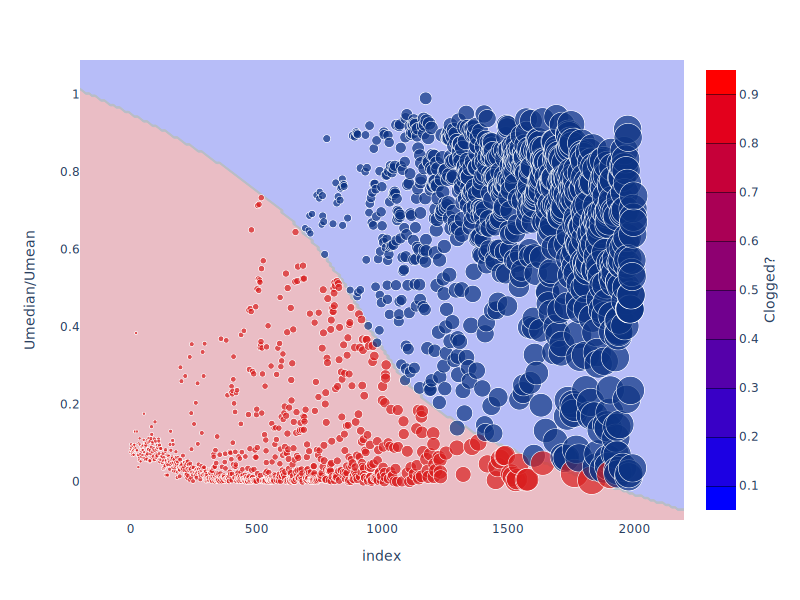

In [114]:
##Ploting Decision Boundaries

#Artificially setting maximum size of symmetry feature to keep graph scale readable
data_cut[data['Umedian/Umean'] > 25] = 25 

#Deciding which features to plot against each other 
#here we chose 2 but can choose any number of features
boundFeatures = ['index','Umedian/Umean'] 

#Plotting the Contours
for i in range(len(boundFeatures)):
    for j in range((i+1),len(boundFeatures)):
        plotDecisionBoundaries(MLPClassifier(activation='logistic', alpha=0.05, batch_size='auto',
                   beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
                   hidden_layer_sizes=(175,), learning_rate='adaptive',
                   learning_rate_init=0.001, max_iter=1000, momentum=0.9,
                   n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
                   random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
                  validation_fraction=0.1, verbose=False, warm_start=False),boundFeatures[i],boundFeatures[j],data_cut.reset_index()
,True,200,'bluered','portland')


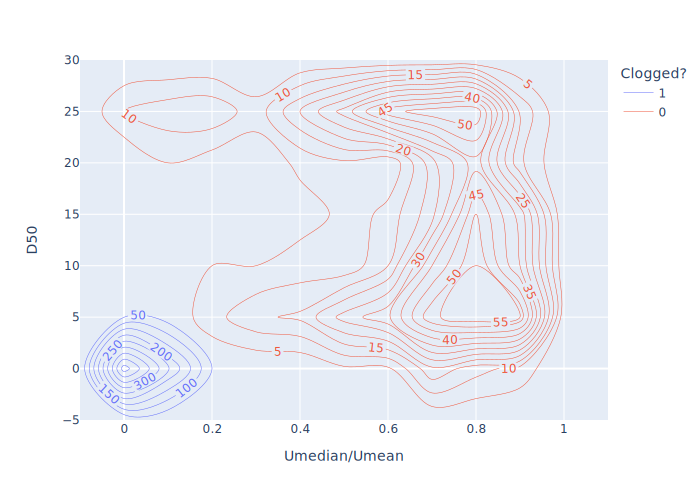

In [113]:
#Plotting Density Contour Plots

density_plt = px.density_contour(data.reset_index(), y='D50', x="Umedian/Umean",color='Clogged?')
density_plt.update_traces(contours_showlabels = True)
density_plt.show(renderer="svg")


# Classification of Clogged and Unclogged Samples

## Defining Functions For Classifier Evaluation

In [156]:
###Defining Classifier Regression Functions

def separateData(data,nSplits,normalize=True):
    """Separate data into training and testing data using k-folds
    with the option to normalize"""
    
    dummy = data.copy()
    scaler = preprocessing.MinMaxScaler() 

    #separating into training and test data
    kfold = model_selection.KFold(n_splits = nSplits, shuffle = True, random_state = 42)
    result = next(kfold.split(dummy), None)
    
    #select the tranining set obtained from kfolds
    train = dummy.iloc[result[0]] 
    trainData = train.drop(['Clogged?'],axis=1)
    trainResult = train['Clogged?']
    
    #select the testing set obtained from kfolds
    test =  dummy.iloc[result[1]]
    testData = test.drop(['Clogged?'],axis=1)
    testResult = test['Clogged?']

    #Normalazing\Scaling data and recasting
    if normalize == True:
        scaler.fit(trainData)  
        scaled_train = scaler.fit_transform(trainData.values)
        trainData = pd.DataFrame(scaled_train, index=trainData.index, columns=trainData.columns)
        scaled_test = scaler.fit_transform(testData.values)
        testData = pd.DataFrame(scaled_test, index=testData.index, columns=testData.columns)
    
        return trainData, trainResult, testData, testResult, scaler
    
    else:
        
        return trainData, trainResult, testData, testResult


def ClassificationModel(model, trainData, trainResult, testData, testResult, printBool):
    """Setup pipline for training and evaluation of different models"""
    
    #choosing model and scaler
    mod =  model
    scaler = preprocessing.MinMaxScaler() 
    
    #establishing the pipeline
    pipeline= Pipeline(steps=[
    ('scaler', scaler),
    ('model', mod),
    ])
    
    #fitting and prediction
    mod_pipeline = pipeline.fit(trainData, trainResult)
    prediction = mod_pipeline.predict(testData)
    probs = mod_pipeline.predict_proba(testData)
    probs = probs[:, 1]
    score = mod_pipeline.score(testData,testResult)
    tn, fp, fn, tp = confusion_matrix(testResult,prediction).ravel()
    
    #identifying misclasified samples
    misclassified_samples = testData[testResult != prediction]

    #performing feature importance analysis
    perm = PermutationImportance(mod_pipeline, cv = None, refit = False, n_iter = 50).fit(trainData, trainResult) 
    featureImp = pd.DataFrame(perm.feature_importances_).transpose()
    featureImp.columns = list(testData.columns.values)
    featureImp = featureImp.transpose()
    featureImp.sort_values(0, inplace=True, ascending=False)
    
    #printing evaluation results if need be
    if printBool == True:
        print(type(mod).__name__)
        print("Accuracy:",score)
        print("Precision Score:",average_precision_score(testResult,prediction))
        print("ROC area under curve:", roc_auc_score(testResult,probs))
        print("True Positives:", tp)
        print("False Positives:", fp)  
        print("True Negatives:", tn)
        print("False Negatives:", fn)
        print(confusion_matrix(testResult,prediction),"\n")
    
        print('Feature Importances:')
        print(featureImp, "\n")
            
    #printing results
    return [score,
            average_precision_score(testResult,prediction),
            roc_auc_score(testResult,probs),tp,fp,tn,fn], \
            featureImp, \
            misclassified_samples.index.values

#Defining Grid Search For Classifiers
def GridSearchClass(model,params, trainData, trainResult, testData, testResult):
    """Set up grid search function for classifiers. This is used to optimize 
    the hyperparameters of the chosen models"""

    ##Selecting Model and Parameters
    mod = model
    parameter_space = params
   
    #Performing Grid Search: scoring can be "accuracy", "balanced_accuracy","average_precision","roc_auc"
    GS = GridSearchCV(model, parameter_space, scoring= "accuracy", cv=5)
    GS.fit(trainData,trainResult)
    bestMod = GS.best_estimator_
    print(bestMod)
    
    ##Finding scoring parameters for best estimator
    score = ClassificationModel(bestMod, trainData, trainResult, testData, testResult,True)    

## Classifier Evaluation

In [143]:
#Separate Data Intro Tranining and Testing Data With K-Folds
trainDataC, trainResultC, testDataC, testResultC  = separateData(apData,5,False)

# Selecting the Classifiers to Study
Classifiers = [
               SGDClassifier(max_iter=1000, tol=1e-3, loss = 'log'),
    
               LogisticRegression(penalty = "l2",solver='liblinear',max_iter=1000,C=0.1),
    
               RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0,oob_score=True),
    
               KNeighborsClassifier(n_neighbors=5),
    
               BernoulliNB(),

               GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None,
                           random_state=32, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False),
    
               AdaBoostClassifier(ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                   max_depth=20, max_features='auto', max_leaf_nodes=None,
                   min_impurity_decrease=0.0, min_impurity_split=None,
                   min_samples_leaf=1, min_samples_split=2,
                   min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
                   oob_score=False, random_state=32, verbose=0, warm_start=False)),
    
               ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                     max_depth=15, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=4,
                     min_weight_fraction_leaf=0.0, n_estimators=400,
                     n_jobs=None, oob_score=False, random_state=32, verbose=0,
                     warm_start=False),
    
               MLPClassifier(activation='logistic', alpha=0.05, batch_size='auto',
                   beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
                   hidden_layer_sizes=(175,), learning_rate='adaptive',
                   learning_rate_init=0.001, max_iter=2500, momentum=0.9,
                   n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
                   random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
                   validation_fraction=0.1, verbose=False, warm_start=False)
               ]

#initializing score and feature matrix
scoresClass = pd.DataFrame(columns = ['Classifier','Accuracy','Precision','ROC',"Tp","Fp","Tn","Fn"])

#Running Classifier Fits and Evaluation Metrics
n=0
bestFeatures={}
indexesMisclass={}
for Class in Classifiers:
    scoresClass.loc[n,'Classifier'] = type(Class).__name__
    scoresClass.loc[n,1:],bestFeatures[type(Class).__name__],indexesMisclass[type(Class).__name__] = ClassificationModel(Class, trainDataC, trainResultC, testDataC, testResultC, False)
    n+=1

#printing the results
print(scoresClass)


                   Classifier Accuracy Precision       ROC   Tp  Fp   Tn   Fn
0               SGDClassifier   0.8725  0.845426  0.933623  160  12  189   39
1          LogisticRegression     0.86  0.805872  0.919623  173  30  171   26
2      RandomForestClassifier     0.82  0.774731  0.923798  151  24  177   48
3        KNeighborsClassifier    0.925  0.892428  0.970174  184  15  186   15
4                 BernoulliNB   0.5575  0.529864  0.554751   98  76  125  101
5  GradientBoostingClassifier     0.96  0.941214   0.98715  191   8  193    8
6          AdaBoostClassifier    0.955  0.930043     0.982  192  11  190    7
7        ExtraTreesClassifier   0.9625  0.941638  0.984275  193   9  192    6
8               MLPClassifier   0.9475  0.920555  0.984025  190  12  189    9


In [154]:
# Looking at the misclassified instances of the best classifier (Extra Trees)

data.iloc[indexesMisclass['ExtraTreesClassifier']]['Clogging_Metric'].head(n=5)

303    0.003187
581    0.365673
618    0.749694
620    1.116787
987    1.150774
Name: Clogging_Metric, dtype: float64

We can see here that most of the misclassified samples are close to the decsicion boundary of the clogging metric = 1. 

## Grid Search and Best Features (only ran for best model for brevity)

In [155]:
##Doing Grid Search on Models 
ETClassParams = {
        'n_estimators' : [300,375,400,425],
        'max_depth': [None,10,15,20,25],
        'min_samples_split': [2,4,6,8], 
        'min_samples_leaf': [1,2,4],
        'criterion': ['entropy']
        }

MLPClassParams = {
        'hidden_layer_sizes': [(100,),(125,),(150,),(175,),(200,)],
        'activation': ['logistic','tanh','relu'],
        'solver': ['adam','lbfgs'], #‘sgd’
        'alpha': [0.001,0.005,0.01,0.05,0.1],
        'learning_rate': ['constant','adaptive'],
        }

RFClassParams = {
        'n_estimators' : [5,10,25,100,200],
        'max_depth': [None,2,5,10,20],
        'min_samples_split': [2,4,6,8], 
        'min_samples_leaf': [1,2,4]
        }

KNNClassParams = {
        'n_neighbors' : [21,22,23,24,25,26,27,28,29,30],
        'weights': ['uniform','distance'],
        'algorithm': ['ball_tree','kd_tree','brute'], 
        }

GBClassParams = {
        'loss' : ['deviance'],#,'exponential'],
        'n_estimators' : [100,250,300,350,400],
        'criterion' : ['friedman_mse'],#,'mse','mae']
        'max_depth': [None,2,5,10,20],
        'min_samples_split': [2,4,6,8], 
        'min_samples_leaf': [1,2,4]
        }


GridSearchClass(ExtraTreesClassifier(random_state=32), ETClassParams, trainDataC, trainResultC, testDataC, testResultC) 

#GridSearchClass(MLPClassifier(random_state=32), MLPClassParams, trainDataC, trainResultC, testDataC, testResultC) 
#GridSearchClass(RandomForestClassifier(random_state=32), RFClassParams,trainDataC, trainResultC, testDataC, testResultC) 
#GridSearchClass(KNeighborsClassifier(),KNNClassParams,trainDataC, trainResultC, testDataC, testResultC) 
#GridSearchClass(GradientBoostingClassifier(random_state=32), GBClassParams,trainDataC, trainResultC, testDataC, testResultC) 

ExtraTreesClassifier(criterion='entropy', max_depth=15, min_samples_split=8,
                     n_estimators=425, random_state=32)
ExtraTreesClassifier
Accuracy: 0.9575
Precision Score: 0.9386971473529262
ROC area under curve: 0.984374609365234
True Positives: 190
False Positives: 8
True Negatives: 193
False Negatives: 9
[[193   8]
 [  9 190]] 

Feature Importances:
                        0
d/Thickness      0.158500
d/D              0.148325
Throat_Flux      0.114887
AWND             0.044675
U_scaled         0.041037
AAND             0.019163
d/R              0.019037
log(nu)          0.017012
D/R              0.008275
Thickness/D      0.007150
Volume_Fraction  0.005950 



## Evaluation performance with only top 5 features

In [157]:
#Checking the results with only 5 number of features

best_5 = ['D/R', 'd/Thickness','Throat_Flux', "U_scaled", 'AWND']

scoresMLP,bestFeaturesMLP, indexes = ClassificationModel(ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=15, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=32, verbose=0, warm_start=False), trainDataC[best_5], trainResultC, testDataC[best_5], testResultC, True)

ExtraTreesClassifier
Accuracy: 0.92
Precision Score: 0.8757228083545691
ROC area under curve: 0.9492112302807569
True Positives: 189
False Positives: 22
True Negatives: 179
False Negatives: 10
[[179  22]
 [ 10 189]] 

Feature Importances:
                    0
d/Thickness  0.366687
Throat_Flux  0.117187
U_scaled     0.076787
AWND         0.060512
D/R          0.032887 



# Regression Study of the Degree of of Clogging in the Samples

## Defining Regression Functions

In [159]:
def separateDataReg(data,nSplits,predictedFeature):
    """Separating continous data into training and testing data through k folds"""
    dummy = data.copy()
    
    #separating into training and test data
    kfold = model_selection.KFold(n_splits = nSplits, shuffle = True, random_state = 42)
    result = next(kfold.split(dummy), None)
    
    #selecting training data
    train = dummy.iloc[result[0]] 
    trainData = train.drop([predictedFeature],axis=1)
    trainResult = train[predictedFeature]
    
    #selecting testing data
    test =  dummy.iloc[result[1]]
    testData = test.drop([predictedFeature],axis=1)
    testResult = test[predictedFeature]
    
    ##Normalaze data if using neural networks
    #scaler = preprocessing.StandardScaler()# (best for MLP)
    #scaler = preprocessing.MinMaxScaler()#  (best for SVR and KKN)

    #scaler.fit(trainData)  
    #scaled_train = scaler.fit_transform(trainData.values)
    #trainData = pd.DataFrame(scaled_train, index=trainData.index, columns=trainData.columns)
    #scaled_test = scaler.fit_transform(testData.values)
    #testData = pd.DataFrame(scaled_test, index=testData.index, columns=testData.columns)
    
    return trainData, trainResult, testData, testResult

def RegressionModel(model, trainData, trainResult, testData, testResult):
    """Creating pipline for tranining and evaluation regressors
    Also prints a graph of the results"""
    
    mod =  model
    mod.fit(trainData,trainResult)
    prediction = mod.predict(testData)
    score = mod.score(testData,testResult)
    explainedVar = explained_variance_score(testResult,prediction)
    MAE = mean_absolute_error(testResult,prediction)
    print(type(model).__name__)
    print("R^2 Score:", score)
    print("Explained Variance Score:",explainedVar)
    print("Mean Absolute Error:",MAE,'\n')
    
    figure = go.Figure()
    
    figure.add_trace(go.Scatter(x=testResult,y=testResult,mode='lines'))
    figure.add_trace(go.Scatter(x=testResult,y=prediction,mode='markers'))

    figure.show(renderer="svg")

    return [score, explainedVar, MAE]

def GridSearchReg(model,params, trainData, trainResult, testData, testResult):
    """Implementaiton of grid search algorithm for model optimization"""

    ##Selecting Model and Parameters
    mod = model
    parameter_space = params
   
    #scoring can be 'r2', ‘neg_mean_absolute_error’, or ‘explained_variance’ 
    GS = GridSearchCV(model, parameter_space, scoring= "r2", cv=5)#, iid = True) #iid = True
    GS.fit(trainData,trainResult)
    bestMod = GS.best_estimator_
    print(bestMod)
    
    ##Finding scoring parameters for best estimator
    score = RegressionModel(bestMod, trainData, trainResult, testData, testResult)


# Regressor Evaluation

GradientBoostingRegressor
R^2 Score: 0.8628080381851118
Explained Variance Score: 0.8628417334215188
Mean Absolute Error: 0.3365035639754255 



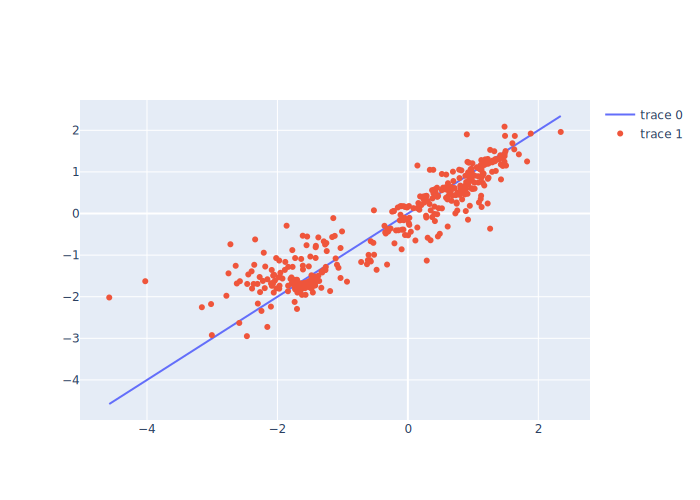

KNeighborsRegressor
R^2 Score: 0.44767137975239735
Explained Variance Score: 0.4486879796473564
Mean Absolute Error: 0.7613022480306136 



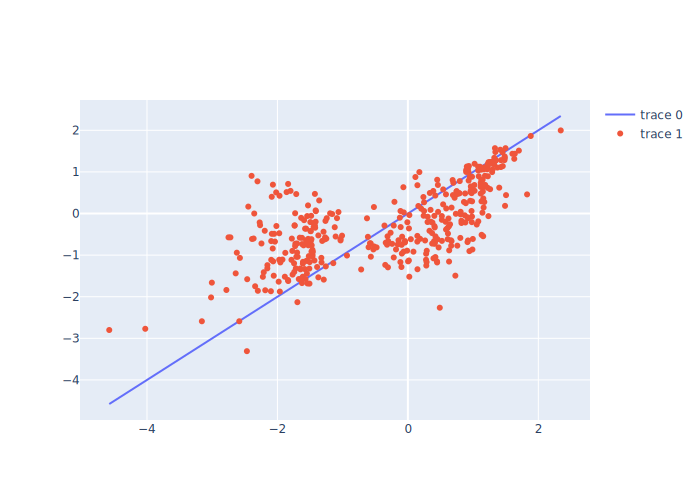

BaggingRegressor
R^2 Score: 0.8992835244653948
Explained Variance Score: 0.8995384591699538
Mean Absolute Error: 0.2298101697802327 



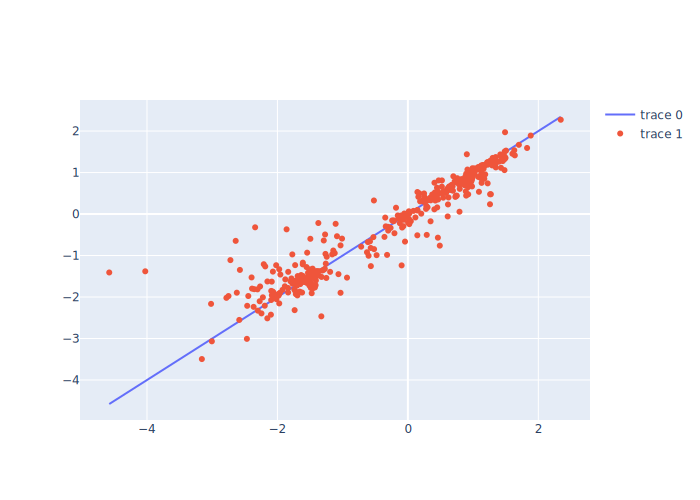

AdaBoostRegressor
R^2 Score: 0.5792383680078523
Explained Variance Score: 0.5935788245407295
Mean Absolute Error: 0.7151315496530489 



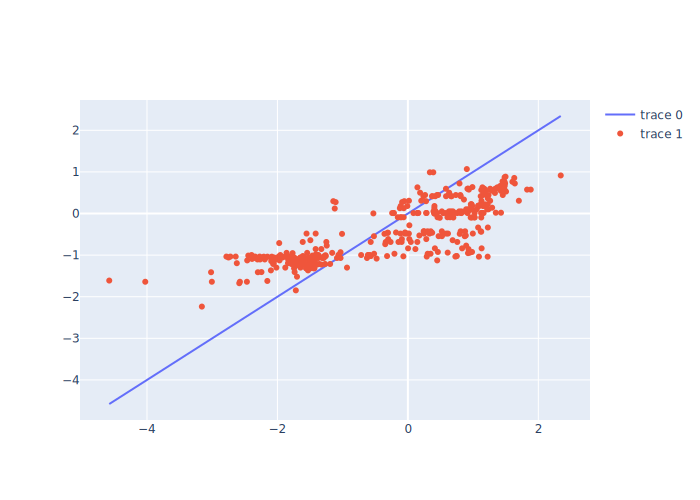

ExtraTreesRegressor
R^2 Score: 0.8847670697479633
Explained Variance Score: 0.8848395219181914
Mean Absolute Error: 0.2280172959655318 



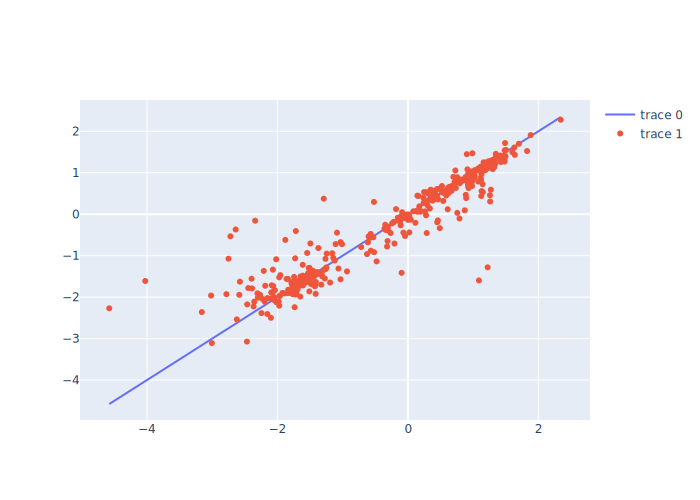

RandomForestRegressor
R^2 Score: 0.9014761191922394
Explained Variance Score: 0.9019741416598784
Mean Absolute Error: 0.22482287289393368 



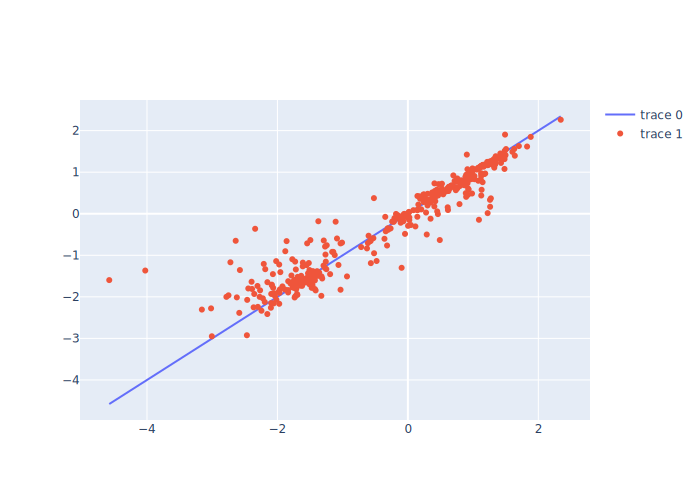

                   Regressor       R^2 Explained Variance Score       MAE
0  GradientBoostingRegressor  0.862808                 0.862842  0.336504
1        KNeighborsRegressor  0.447671                 0.448688  0.761302
2           BaggingRegressor  0.899284                 0.899538   0.22981
3          AdaBoostRegressor  0.579238                 0.593579  0.715132
4        ExtraTreesRegressor  0.884767                  0.88484  0.228017
5      RandomForestRegressor  0.901476                 0.901974  0.224823


In [161]:
##Separating Data Through K Means
trainDataR, trainResultR, testDataR, testResultR  = separateDataReg(apDataReg.sample(frac=1),5,'Clogging_Metric')

#taking the logarithm of the log function to prevent overfitting MAE bias for large clogging number values
trainResultR = np.log10(trainResultR)
testResultR = np.log10(testResultR)

##Defining Regressors to Study
#some are commented out for presentation brevity

Regressors = [
            #LinearRegression(),
    
            #SVR(),
    
            GradientBoostingRegressor(),
    
            KNeighborsRegressor(),
    
            BaggingRegressor(),
    
            AdaBoostRegressor(),
    
            ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
                oob_score=False, random_state=None, verbose=0, warm_start=False),
    
            RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                oob_score=False, random_state=None, verbose=0, warm_start=False),
    
            #MLPRegressor(activation='relu', alpha=0.5, batch_size='auto', beta_1=0.9,
            #    beta_2=0.999, early_stopping=False, epsilon=1e-08,
            #    hidden_layer_sizes=(100,), learning_rate='adaptive',
            #    learning_rate_init=0.001, max_iter=1000, momentum=0.9,
            #    n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
            #    random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
            #    validation_fraction=0.1, verbose=False, warm_start=False)
            ]

#initializing score and feature matrix
scoresReg = pd.DataFrame(columns = ['Regressor','R^2','Explained Variance Score','MAE'])

##Running Fits and Evaluation Metrics
n=0
for Reg in Regressors:
    scoresReg.loc[n,'Regressor'] = type(Reg).__name__
    scoresReg.loc[n,1:] = RegressionModel(Reg, trainDataR, trainResultR, testDataR, testResultR)
    n+=1
    
print(scoresReg)
    

## Performing Grid Search on Regressors (only done on one model here for brevity)


ExtraTreesRegressor(n_estimators=24)
ExtraTreesRegressor
R^2 Score: 0.8931727332554978
Explained Variance Score: 0.8933846344734595
Mean Absolute Error: 0.21922582266503965 



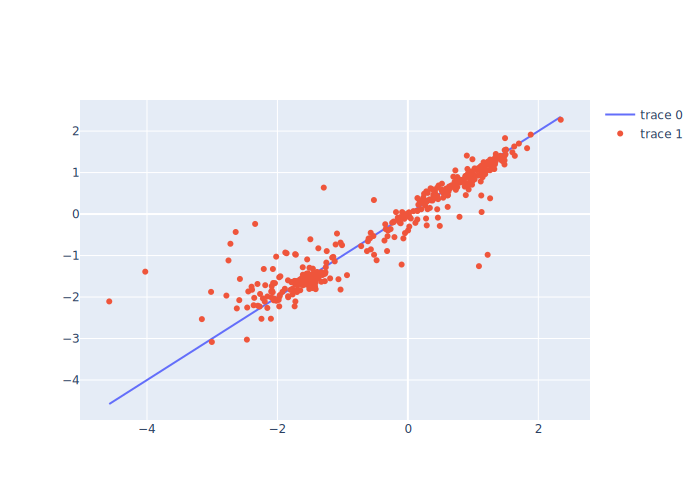

In [162]:
## Performing Grid Search on Regressors

ETRegParams = {
        'n_estimators' : [23,24,25,26,27],
        'max_depth': [None,2,5,10,20],
        'min_samples_split': [2,4,6,8], 
        'min_samples_leaf': [1,2,4]
        }

MLPRegParams = {
        'hidden_layer_sizes': [(275,),(400,),(500,),(600,),(700,)],
        #'activation': ['logistic','tanh'], #'relu'
        #'solver': ['adam','lbfgs','sgd'], #‘sgd’
        #'alpha': [0.475,0.5,0.525,]
        #'learning_rate': ['constant','adaptive'],
        }

RFRegParams = {
        'n_estimators' : [5,10,25,100,200],
        'max_depth': [None,2,5,10,20],
        'min_samples_split': [2,4,6,8], 
        'min_samples_leaf': [1,2,4]
        }


GridSearchReg(ExtraTreesRegressor(),ETRegParams, trainDataR, trainResultR, testDataR, testResultR) 
#GridSearchReg(MLPRegressor(max_iter=1000, learning_rate = 'adaptive', solver = 'lbfgs', alpha=0.5), MLPRegParams, trainDataR, trainResultR, testDataR, testResultR) 
#GridSearchReg(RandomForestRegressor(),RFRegParams, trainDataR, trainResultR, testDataR, testResultR) 

In [ ]:
#Feature importance:

ETR = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
                oob_score=False, random_state=None, verbose=0, warm_start=False)

top = trainDataR.columns# ['D/R','d/Thickness','Throat_Flux',"U_scaled", 'AWND']

ETR.fit(trainDataR[top], trainResultR)
prediction = ETR.predict(testDataR[top])
score = ETR.score(testDataR[top],testResultR)
featureImp = pd.DataFrame(ETR.feature_importances_).transpose()
featureImp.columns = list(trainDataR[top].columns.values)
featureImp = featureImp.transpose()
featureImp.sort_values(0, inplace=True, ascending=False)
print(score)
print(featureImp)

# Saving Best Classifing and Regression Models

In [167]:
#Training best classifier with a piplene object on the whole data set

scaler_C = preprocessing.MinMaxScaler() 
ETC = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                     max_depth=15, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=400,
                     n_jobs=None, oob_score=False, random_state=32, verbose=0,
                     warm_start=False)

pipeline= Pipeline(steps=[
    ('scaler', scaler_C),
    ('model', ETC),
])

ETC_Pipeline = pipeline.fit(apData.drop(["Clogged?"],axis=1), apData["Clogged?"])

#Training Best Regressor on the whole data set

ETR = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
                oob_score=False, random_state=None, verbose=0, warm_start=False)

ETR.fit(apDataReg.drop(["Clogging_Metric"],axis=1), apDataReg["Clogging_Metric"])

#Exporting models
ETC_filename = 'Classifier_Model_All_Features_new.joblib'
ETR_filename = 'Regression_Model_All_Features_new.joblib'
joblib.dump(ETC_Pipeline, ETC_filename)
joblib.dump(ETR, ETR_filename)

['Regression_Model_All_Features_new.joblib']

# Additional Representative Graphs (2D and 3D)

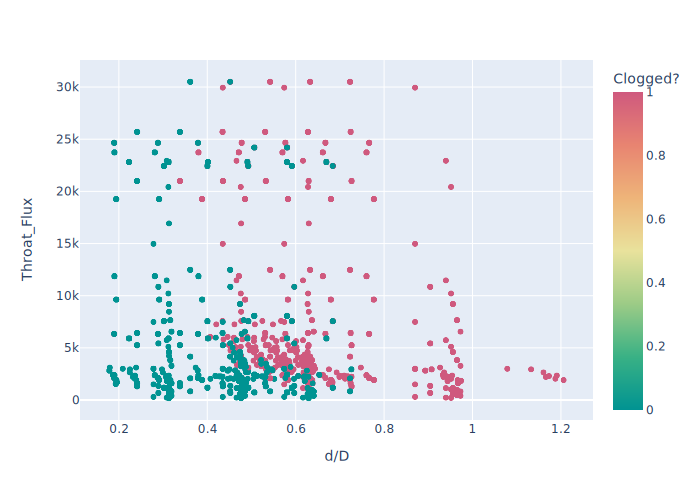

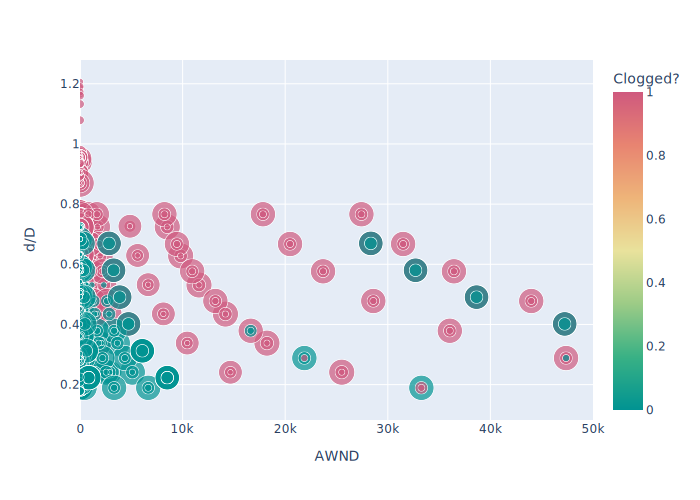

In [170]:
# 2D graphs
scatter2D = px.scatter(data.reset_index(), x='d/D', y='Throat_Flux',color='Clogged?',color_continuous_scale='temps')    
scatter2D.show()

scatter2D = px.scatter(data.reset_index(), x='AWND', y='d/D',color='Clogged?',color_continuous_scale='temps',size='Throat_Flux')    
scatter2D.update_xaxes(range=[0, 50000])
scatter2D.show()

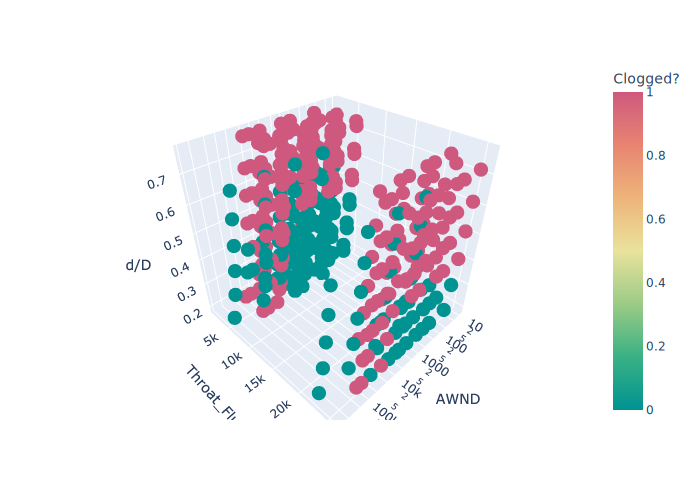

In [171]:
#3D Graphs
scatter3D = px.scatter_3d(data.reset_index(), x='AWND', y="Throat_Flux", z = 'd/D', color='Clogged?',color_continuous_scale='temps',log_x=True)   
scatter3D.update_xaxes(range=[0, 10000])
scatter3D.show()